# Land cover classification at the Mississppi Delta

In this notebook, you will use a k-means **unsupervised** clustering
algorithm to group pixels by similar spectral signatures. **k-means** is
an **exploratory** method for finding patterns in data. Because it is
unsupervised, you don’t need any training data for the model. You also
can’t measure how well it “performs” because the clusters will not
correspond to any particular land cover class. However, we expect at
least some of the clusters to be identifiable as different types of land
cover.

You will use the [harmonized Sentinal/Landsat multispectral
dataset](https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf).
You can access the data with an [Earthdata
account](https://www.earthdata.nasa.gov/learn/get-started) and the
[`earthaccess` library from
NSIDC](https://github.com/nsidc/earthaccess):

## STEP 1: SET UP

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Import all libraries you will need for this analysis</li>
<li>Configure GDAL parameters to help avoid connection errors:
<code>python      os.environ["GDAL_HTTP_MAX_RETRY"] = "5"      os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"</code></li>
</ol></div></div>

In [1]:
import os
import pathlib
import pickle
import re
import warnings

import cartopy.crs as ccrs
import earthaccess
import earthpy as et
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
from tqdm.notebook import tqdm
import xarray as xr
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
import zipfile

os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

warnings.simplefilter('ignore')

c:\Users\riede\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Make data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'mississippi-delta'
    )

os.makedirs(data_dir, exist_ok=True)

data_dir

'C:\\Users\\riede\\earth-analytics\\data\\mississippi-delta'

Below you can find code for a caching **decorator** which you can use in
your code. To use the decorator:

``` python
@cached(key, override)
def do_something(*args, **kwargs):
    ...
    return item_to_cache
```

This decorator will **pickle** the results of running the
`do_something()` function, and only run the code if the results don’t
already exist. To override the caching, for example temporarily after
making changes to your code, set `override=True`. Note that to use the
caching decorator, you must write your own function to perform each
task!

In [3]:
def cached(func_key, override=False):
    """
    A decorator to cache function results
    
    Parameters
    ==========
    key: str
      File basename used to save pickled results
    override: bool
      When True, re-compute even if the results are already stored
    """
    def compute_and_cache_decorator(compute_function):
        """
        Wrap the caching function
        
        Parameters
        ==========
        compute_function: function
          The function to run and cache results
        """
        def compute_and_cache(*args, **kwargs):
            """
            Perform a computation and cache, or load cached result.
            
            Parameters
            ==========
            args
              Positional arguments for the compute function
            kwargs
              Keyword arguments for the compute function
            """
            # Add an identifier from the particular function call
            if 'cache_key' in kwargs:
                key = '_'.join((func_key, kwargs['cache_key']))
            else:
                key = func_key

            path = os.path.join(
                et.io.HOME, et.io.DATA_NAME, 'jars', f'{key}.pickle')
            
            # Check if the cache exists already or override caching
            if not os.path.exists(path) or override:
                # Make jars directory if needed
                os.makedirs(os.path.dirname(path), exist_ok=True)
                
                # Run the compute function as the user did
                result = compute_function(*args, **kwargs)
                
                # Pickle the object
                with open(path, 'wb') as file:
                    pickle.dump(result, file)
            else:
                # Unpickle the object
                with open(path, 'rb') as file:
                    result = pickle.load(file)
                    
            return result
        
        return compute_and_cache
    
    return compute_and_cache_decorator

## STEP 2: STUDY SITE

For this analysis, you will use a watershed from the [Water Boundary
Dataset](https://www.usgs.gov/national-hydrography/access-national-hydrography-products),
HU12 watersheds (WBDHU12.shp).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Water Boundary Dataset for region 8 (Mississippi)</li>
<li>Select watershed 080902030506</li>
<li>Generate a site map of the watershed</li>
</ol>
<p>Try to use the <strong>caching decorator</strong></p></div></div>

We chose this watershed because it covers parts of New Orleans and is
near the Mississippi Delta. Deltas are boundary areas between the land
and the ocean, and as a result tend to contain a rich variety of
different land cover and land use types.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-response"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>Write a 2-3 sentence <strong>site description</strong> (with
citations) of this area that helps to put your analysis in context.</p></div></div>

**SEE SITE DESCRIPTION BELOW SITE MAP**

* Helpful links:

    * URL for WBD region 8: https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_08_HU2_Shape.zip

    * Documentation for et.data.get_data: https://earthpy.readthedocs.io/en/latest/gallery_vignettes/get_data.html

    * Documentation for .dissolve(): https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html

<span style="color: purple;">

#### STEP 2a. Download watershed boundary data for region 8

</span>

In [4]:
# call cached decorator
@cached('wbd', override=False)
# add function to apply decorator abilities to
def read_wbd_file(wbd_filename, huc_level, cache_key):
    # Define wbd_url
    wbd_url = (
        "https://prd-tnm.s3.amazonaws.com"
        "/StagedProducts/Hydrography/WBD/HU2/Shape/"
        f"{wbd_filename}.zip")
    # et.data.get_data from earthpy library to download data from a zip file
    # can also download Earthpy Dataset Subsets w/ et.data.get_data 
    wbd_dir = et.data.get_data(url=wbd_url)
                  
    # Read desired data
    wbd_path = os.path.join(wbd_dir, 'Shape', f'WBDHU{huc_level}.shp')
    # engine is the library used to read the file
    wbd_gdf = gpd.read_file(wbd_path, engine='pyogrio')
    return wbd_gdf

# define huc_level
huc_level = 12

# create wbd_total_gdf 
wbd_total_gdf = read_wbd_file(
    # filename found from URL noted above code cell
    wbd_filename = 'WBD_08_HU2_Shape',
    # huc_level defined above
    huc_level = huc_level,
    # cache_key is a kwarg for cached decorator
    cache_key=f'hu{huc_level}'
)

# check wbd_total_gdf
wbd_total_gdf.head()


,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,...,name,hutype,humod,tohuc,noncontrib,noncontr_1,shape_Leng,shape_Area,ObjectID,geometry
0,{8AFB1AF9-7296-4303-89DE-14CD073B859A},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15,"535297,540579",29441.81,119.15,LA,...,Gourd Bayou-Youngs Bayou,S,"LE,ID,DD",080500011308,0.0,0.0,NaN,NaN,1,"POLYGON ((-92.00021 32.53586, -91.99994 32.535..."
1,{916A17A6-B4A0-4FD7-9BB8-FFD1936B15B2},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15,535512,11406.67,46.16,LA,...,Hams Creek,S,ID,080802050104,0.0,0.0,NaN,NaN,2,"POLYGON ((-93.37574 30.58982, -93.3747 30.5891..."
2,{493C7EC1-2F1C-4B84-AFFB-6F6868A9868E},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15,"547190,559640",29138.21,117.92,LA,...,Caney Creek-Bayou D'Arbonne,S,NM,080402060503,0.0,0.0,NaN,NaN,3,"POLYGON ((-93.07761 32.88752, -93.07784 32.887..."
3,{49A3C087-B460-4F97-9D99-78CBB675248B},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15,"77417,78285",17759.39,71.87,AR,...,L'Aigle Creek-Saline River,S,NM,080402020206,0.0,0.0,NaN,NaN,4,"POLYGON ((-92.08947 33.29383, -92.0897 33.2938..."
4,{0FB41498-11EA-4AB1-AF05-E2A8E5E2E274},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15,1628466,98564.62,398.88,LA,...,West Cote Blanche Bay,W,NM,080801030800,0.0,0.0,NaN,NaN,5,"POLYGON ((-91.62408 29.73947, -91.62195 29.737..."


<span style="color: purple;">

#### STEP 2b. Select watershed of interest from region 8, 080902030506

</span>

In [5]:
# see all column names of the wbd_total_gdf
wbd_total_gdf.columns

Index(['tnmid', 'metasource', 'sourcedata', 'sourceorig', 'sourcefeat',
       'loaddate', 'referenceg', 'areaacres', 'areasqkm', 'states', 'huc12',
       'name', 'hutype', 'humod', 'tohuc', 'noncontrib', 'noncontr_1',
       'shape_Leng', 'shape_Area', 'ObjectID', 'geometry'],
      dtype='object')

In [6]:
# select the 080902030506 rows from the wbd_total_gdf
wbd_gdf = (
    # from the huc12 column...
    wbd_total_gdf[wbd_total_gdf[f'huc{huc_level}']
    # select only the rows for 080902030506
    .isin(['080902030506'])]
    # dissolve all geometries to a single geometric feature
    # and aggreagate all rows of data in a group
    .dissolve()
)

# check wbd_gdf
wbd_gdf

,geometry,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,...,huc12,name,hutype,humod,tohuc,noncontrib,noncontr_1,shape_Leng,shape_Area,ObjectID
0,"POLYGON ((-89.97047 29.74687, -89.96593 29.750...",{E942B72E-599E-48F5-908A-EA5265701C14},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15,"536881,539539",37355.86,151.17,...,080902030506,Manuel Canal-Spanish Lake,D,GC,080902030508,0.0,0.0,NaN,NaN,2560


In [7]:
print(f"Watershed 080902030506 is in {wbd_gdf['states']}")

Watershed 080902030506 is in 0    LA
Name: states, dtype: object


<span style="color: purple;">

#### STEP 2c. Create site map of watershed 080902030506 in Louisiana, USA & describe watershed

</span>

In [8]:
# create site map with hvplot
(
    wbd_gdf
    .hvplot(
        # geographic plot, lat/lon axes
        geo=True,
        # overlay plot on EsriImagery tiles
        tiles='EsriImagery',
        # fill color
        color='white',
        # transparency of fill color
        alpha=0.4,
        # line color
        line_color='red',
        # define title
        title='080902030506 Watershed Boundary in Louisiana, USA',
        # define size of plot
        frame_width=400
    )
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

<span style="color: maroon;">

**SITE DESCRIPTION:**

Watershed 080902030506 is in Louisiana, USA, southeast of New Orleans. According to Naitve Land Digital, the watershed is on the Indigenous territories of the [Chahta Yakni (Choctaw)](https://native-land.ca/maps/territories/chahta-choctaw), [Houma](https://native-land.ca/maps/territories/houma-2), and [Chitimacha](https://native-land.ca/maps/territories/chitimacha-2) people. The Mississippi river runs north to south on the east side of the waterhsed. Lake Lery is on the north east side of the watershed. This watershed is in Louisiana's [8th of 9 watersheds](https://watershed.la.gov/watershed-regions). According to [Louisiana's current Region 8 flood risk report](https://d10zxfp0rexahe.cloudfront.net/docs/Region-8-PDF.pdf), this region of Louisiana is subject to 3 main different types of flooding: fluvial/river, costal/surge and tidal, and pluvial/rainfall-induced flash floods and urban flooding. Watershed 080902030506 is also classified as medium-high in the CDC social vulnerability index based on socioeconimic status, household composition and disability, minority status and language, and housing and transportation. 

</span>

Extra links, may or may not use:

how's my waterway (water condition info): https://mywaterway.epa.gov/community/080902030506/overview

about the wbd: https://www.usgs.gov/national-hydrography/watershed-boundary-dataset


## STEP 3: MULTISPECTRAL DATA

### Search for data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Log in to the <code>earthaccess</code> service using your Earthdata
credentials:
<code>python      earthaccess.login(persist=True)</code></li>
<li>Modify the following sample code to search for granules of the
HLSL30 product overlapping the watershed boundary from May to October
2023 (there should be 76 granules):
<code>python      results = earthaccess.search_data(          short_name="...",          cloud_hosted=True,          bounding_box=tuple(gdf.total_bounds),          temporal=("...", "..."),      )</code></li>
</ol></div></div>

HLSL30 info from the NASA worldview site:

"The Harmonized Landsat Sentinel-2 (HLS) project brings us 30 meter resolution true color surface reflectance imagery from the Operational Land Imager (OLI) instrument aboard the NASA/USGS Landsat 8 and 9 satellites, and the Multi-Spectral Instrument (MSI) aboard the European Space Agency (ESA) Sentinel-2A and Sentinel-2B satellites."

In [9]:
# Log in to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [10]:
# Search for HLS tiles
wbd_hls_results = earthaccess.search_data(
    # dataset short name
    short_name='HLSL30',
    cloud_hosted=True,
    # the bounding box is the waterhsed boundary
    bounding_box=tuple(wbd_gdf.total_bounds),
    # temporal bounds from May - Oct 2023
    temporal=('2023-05-01', '2023-10-31')
)
wbd_hls_results


[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -90.07372506, 'Latitude': 28.80444525}, {'Longitude': -89.57473392, 'Latitude': 28.81489352}, {'Longitude': -89.30816409, 'Latitude': 29.81030157}, {'Longitude': -90.10353675, 'Latitude': 29.79400715}, {'Longitude': -90.07372506, 'Latitude': 28.80444525}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-04T16:31:32.101Z', 'EndingDateTime': '2023-05-04T16:31:55.992Z'}}
 Size(MB): 87.65197467803955
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B07.tif', 'https://data.lp

In [11]:
# add the wbd_hls_results go a geodataframe
wbd_hls_gdf = gpd.GeoDataFrame(wbd_hls_results)
wbd_hls_gdf

,meta,umm,size
0,"{'concept-type': 'granule', 'concept-id': 'G26...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,87.651975
1,"{'concept-type': 'granule', 'concept-id': 'G26...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,150.901505
2,"{'concept-type': 'granule', 'concept-id': 'G26...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,182.547405
3,"{'concept-type': 'granule', 'concept-id': 'G26...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,145.737147
4,"{'concept-type': 'granule', 'concept-id': 'G26...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,98.771830
...,...,...,...
83,"{'concept-type': 'granule', 'concept-id': 'G27...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,156.733950
84,"{'concept-type': 'granule', 'concept-id': 'G27...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,145.328370
85,"{'concept-type': 'granule', 'concept-id': 'G27...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,186.026457
86,"{'concept-type': 'granule', 'concept-id': 'G27...",{'TemporalExtent': {'RangeDateTime': {'Beginni...,97.142883


### Compile information about each granule

I recommend building a GeoDataFrame, as this will allow you to plot the
granules you are downloading and make sure they line up with your
shapefile. You could also use a DataFrame, dictionary, or a custom
object to store this information.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>For each search result:
<ol type="1">
<li>Get the following information (HINT: look at the [‘umm’] values for
each search result):
<ul>
<li>granule id (UR)</li>
<li>datetime</li>
<li>geometry (HINT: check out the shapely.geometry.Polygon class to
convert points to a Polygon)</li>
</ul></li>
<li>Open the granule files. I recomment opening one granule at a time,
e.g. with (<code>earthaccess.open([result]</code>).</li>
<li>For each file (band), get the following information:
<ul>
<li>file handler returned from <code>earthaccess.open()</code></li>
<li>tile id</li>
<li>band number</li>
</ul></li>
</ol></li>
<li>Compile all the information you collected into a GeoDataFrame</li>
</ol></div></div>

#### **Explore HLS data before building GeoDataFrame**

In [12]:
# look at the 'umm' column for the first row
wbd_hls_gdf['umm'].loc[0]

{'TemporalExtent': {'RangeDateTime': {'BeginningDateTime': '2023-05-04T16:31:32.101Z',
   'EndingDateTime': '2023-05-04T16:31:55.992Z'}},
 'GranuleUR': 'HLS.L30.T16RBT.2023124T163132.v2.0',
 'AdditionalAttributes': [{'Name': 'LANDSAT_PRODUCT_ID',
   'Values': ['LC08_L1TP_022039_20230504_20230504_02_RT',
    'LC08_L1TP_022040_20230504_20230504_02_RT']},
  {'Name': 'CLOUD_COVERAGE', 'Values': ['21']},
  {'Name': 'MGRS_TILE_ID', 'Values': ['16RBT']},
  {'Name': 'SPATIAL_COVERAGE', 'Values': ['57']},
  {'Name': 'SPATIAL_RESOLUTION', 'Values': ['30.0']},
  {'Name': 'SPATIAL_RESAMPLING_ALG', 'Values': ['Cubic Convolution']},
  {'Name': 'HLS_PROCESSING_TIME', 'Values': ['2023-05-06T06:52:48Z']},
  {'Name': 'SENSING_TIME',
   'Values': ['2023-05-04T16:31:32.1012330Z', '2023-05-04T16:31:55.9922730Z']},
  {'Name': 'HORIZONTAL_CS_NAME',
   'Values': ['UTM, WGS84, UTM ZONE 15', 'UTM, WGS84, UTM ZONE 15']},
  {'Name': 'ULX', 'Values': ['199980.0']},
  {'Name': 'ULY', 'Values': ['3300000.0']},
  {'N

In [13]:
# isolate the granule ID (UR) for the first row
row1 = list(wbd_hls_gdf['umm'].loc[0].values())
row1[1]

'HLS.L30.T16RBT.2023124T163132.v2.0'

In [14]:
# isolate the datetime for the first row
row1[0]


{'RangeDateTime': {'BeginningDateTime': '2023-05-04T16:31:32.101Z',
  'EndingDateTime': '2023-05-04T16:31:55.992Z'}}

In [15]:
# identify the keys for the first row
# the geometry, 'SpatialExtent' key is index 3
row1_keys = list(wbd_hls_gdf['umm'].loc[0].keys())
row1_keys


['TemporalExtent',
 'GranuleUR',
 'AdditionalAttributes',
 'SpatialExtent',
 'ProviderDates',
 'CollectionReference',
 'RelatedUrls',
 'DataGranule',
 'Platforms',
 'MetadataSpecification']

In [16]:
# isolate the SpatialExtent for the first row
# this is a dictionary
test = row1[3]
test

{'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -90.07372506,
        'Latitude': 28.80444525},
       {'Longitude': -89.57473392, 'Latitude': 28.81489352},
       {'Longitude': -89.30816409, 'Latitude': 29.81030157},
       {'Longitude': -90.10353675, 'Latitude': 29.79400715},
       {'Longitude': -90.07372506, 'Latitude': 28.80444525}]}}]}}}

In [17]:
# The first part of Elsa's loop to compile info abt each granule
# granule = the first result
granule = wbd_hls_results[0]
# look at just the metadata, umm, of the first result
info_dict = granule['umm']
# create a list of all points, lat/lon, for the first result from the umm column of the first result
points = (
    info_dict
    # select the first thing in the GPolygons list
    ['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][0]
    ['Boundary']['Points'])
# create the geometry (Polygon) of the first result using Polygon from shapely
# loop through all the points in our points list and get the lat/long for each one to create the geometry
geometry = Polygon(
    [(point['Longitude'], point['Latitude']) for point in points])

print(points)
print(geometry)

[{'Longitude': -90.07372506, 'Latitude': 28.80444525}, {'Longitude': -89.57473392, 'Latitude': 28.81489352}, {'Longitude': -89.30816409, 'Latitude': 29.81030157}, {'Longitude': -90.10353675, 'Latitude': 29.79400715}, {'Longitude': -90.07372506, 'Latitude': 28.80444525}]
POLYGON ((-90.07372506 28.80444525, -89.57473392 28.81489352, -89.30816409 29.81030157, -90.10353675 29.79400715, -90.07372506 28.80444525))


In [18]:
# open test granule
opened_granule = earthaccess.open([granule])

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

In [19]:
# look at opened_granule
# 15 different .tif files, each for a different band
# All the bands for 1 granule have the same tile_id, geometry, and datetime
opened_granule

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B03.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B07.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B06.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B02.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B01.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

In [20]:
# What type of object is one element of the opened_granule?
type(opened_granule[0])

earthaccess.store.EarthAccessFile

In [21]:
# get tile ids and band numbers for the granule
# Compile a regular expression to search for metadata
# the r indicates this is a raw string and highlights all escaped characters (the dots), limits our need to escape special characters
uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)"
    r"\.\d+T\d+\.v\d\.\d\."
    r"(?P<band_id>[A-Za-z0-9].+)\.tif"
)

#this yields a dictionary with the tile id, date, and band id
# 0 index above is B03, green band
# the date is the 124 day of 2023
uri_re.search(opened_granule[0].full_name).groupdict()

{'tile_id': 'T16RBT', 'band_id': 'B03'}

Use above code to start trying to craft for loop(s)

In [22]:
# Get granule metadata (ID (UR), datetime, and geometry)

## create empty lists to add metadata to
granule_ids = []
granule_datetimes = []
granule_geometries = []

## set up for loop, tqdm creates a progress bar
## for each row in the wbd_gls_results...
for granule in tqdm(wbd_hls_results):
    metadata = granule['umm']
    ## identify the granule_id and append it to the granule_ids list
    granule_id = metadata['GranuleUR']
    granule_ids.append(granule_id)

    ## identify the granule_datetime and append it to the granule_datetimes list
    granule_datetime = pd.to_datetime(metadata
        ['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
    granule_datetimes.append(granule_datetime)

    ## identify the granule_geometry and append it to the granule_geometries list
    ## create a list of all points, lat/lon, for the first result from the umm column of the first result
    points = (
        metadata
        # select the first thing in the GPolygons list
        ['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][0]
        ['Boundary']['Points'])
    ## create the geometry (Polygon) of the first result using Polygon from shapely
    ## loop through all the points in our points list and get the lat/long for each one to create the geometry
    geometry = Polygon(
        [(point['Longitude'], point['Latitude']) for point in points])
    granule_geometries.append(geometry)

  0%|          | 0/88 [00:00<?, ?it/s]

In [23]:
# try to figure out opening each band file from each granule 
# commenting this cell out for now to save time and b/c I have a big loop working below
# ## create empty lists for results
# files = []

# ## open each file in wbd_hls_results
# for row in tqdm(wbd_hls_results):
#     file = earthaccess.open([row])
#     print(file[0])
#     print(type(file[0]))
#     print(file[1])
#     print(type(file[1]))
#     for num in range(0, 15):
#         files.append(file[num])
#         #files list should be 1320 in length

In [24]:
# check length of files list from above
#  len(files)

In [25]:
# Looking at what we can do with the opened bands
# dir(files[0])

In [26]:
# ## Get metadata for files list created above, commenting out for now since it isn't needed
# ## create empty lists for results
# tile_id = []
# band_id = []

# ## compile regular expression to search for metadata - tile_id and band_id
# url_re = re.compile(
#     r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)"
#     r"\.\d+T\d+\.v\d\.\d\."
#     r"(?P<band_id>[A-Za-z0-9].+)\.tif"
# )
# ## use regular expression to search for metadata - tile_id and band_id
# for file in files:
#     # this yields a dictionary with the tile id and band id
#     file_metadata = url_re.search(file.full_name)
#     tile_id.append(file_metadata.group('tile_id'))
#     band_id.append(file_metadata.group('band_id'))

In [27]:
# # check tile_id list
# tile_id

In [28]:
# # check band_id list
# band_id

Code that's working independently: tile_id/band_id lists, files list, and the datetime/geom list. Can we put all those into one loop to hopefully create a gdf where all columns are the same length? Right now my issue is that now that the tile_id/band_id and files lists are working, they're too long for the granule_datetimes and granule_geometries lists. I'm going to try to model this big loop after Elsa's loop. I don't see a great need to make it a function, except that mabye I could cache the results which would be nice. Hopefully I end up w/ a gdf w/ 5 columns and 1320 rows: each set of 15 rows should have the same tile_id, geometry, and datetime, each row w/in the 15 should have it's own band_id, and each row in the whole gdf should have a unique url.

In [29]:
## Tried creating my own loop to create a gdf with granule metadata, took forever and I don't think it worked, not sure why.
## Commenting this out and using Elsa's loop instead
#  def create_granule_gdf(results):
#     """
#     Create a GeoDataFrame with granule metadata: datetime, url, tile_id, band_id, and geometry.
    
#     Parameters:
#     results : list of HLS tiles from searching earthaccess
    
#     Returns:
#     granule_gdf: GeoDataFrame w/ granule metadata
#     """
#     ## compile regular expression to search for metadata - tile_id and band_id
#     url_re = re.compile(
#         r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)"
#         r"\.\d+T\d+\.v\d\.\d\."
#         r"(?P<band_id>[A-Za-z0-9].+)\.tif"
#         )
#     ## loop through each granule to get datetime and geometry
#     ## empty lists for datetimes and geometries
#     #granule_datetimes = []
#     #geometries = []
#     link_rows =[]

#     ## set up for loop, tqdm creates a progress bar
#     ## for each row in the wbd_gls_results...
#     for granule in tqdm(results):
#         metadata = granule['umm']
#         ## identify the granule_datetime and append it to the granule_datetimes list
#         granule_datetime = pd.to_datetime(metadata
#             ['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
#         #granule_datetimes.append(granule_datetime)
#         #print(granule_datetime)

#         ## identify the granule_geometry and append it to the granule_geometries list
#         ## create a list of all points, lat/lon, for the first result from the umm column of the first result
#         points = (
#             metadata
#             # select the first thing in the GPolygons list
#             ['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][0]
#             ['Boundary']['Points'])
#         ## create the geometry (Polygon) of the first result using Polygon from shapely
#         ## loop through all the points in our points list and get the lat/long for each one to create the geometry
#         geometry = Polygon(
#             [(point['Longitude'], point['Latitude']) for point in points])
#         #geometries.append(geometry)
#         #print(geometry)

#         # Get granule url by opening each file in results
#         files=[]
#         for granule in tqdm(results):
#             file_indiv = earthaccess.open([granule])
#             print(file_indiv[0])
#             print(type(file_indiv[0]))
#             print(file_indiv[1])
#             print(type(file_indiv[1]))
#             for num in range(0, 15):
#                 files.append(file_indiv[num])
#                 #files list should be 1320 in length

#         ## use regular expression to search for metadata - tile_id and band_id
#         # tile_ids = []
#         # band_ids = []
#         for file in files:
#             # this yields a dictionary with the tile id and band id
#             file_metadata = url_re.search(file.full_name)
#             # tile_ids.append(file_metadata.group('tile_id'))
#             # band_ids.append(file_metadata.group('band_id'))

#             # Create metadata DataFrame
#             if file_metadata is not None:
#                 link_rows.append(
#                     gpd.GeoDataFrame(
#                         dict(
#                             granule_datetime = [granule_datetime],
#                             tile_ids = [file_metadata.group('tile_id')],
#                             band_ids = [file_metadata.group('band_id')],
#                             url = [file],
#                             geometry = [geometry]
#                             ),
#                             crs='EPSG:4326'
#                     )
#                 )
#     # Concatenate metadata DataFrame
#     file_df = pd.concat(link_rows.reset_index)(drop=True)
#     return file_df

In [30]:
## Try using my loop to greate a gdf w/ granule metadata
## Took forever, don't think it worked :(
# create_granule_gdf(wbd_hls_results)

In [31]:
## When I had the individual parts of my loops working, this was to create the gdf with my granule metadata. ran into issues b/c the metadata lists weren't the same length
#  # Create dictionary to hold metadata lists
# metadata_dict = ({'granule_datetime' : granule_datetimes,
#                   'url' : files,
#                   'tile_id' : tile_id,
#                   'band_id' : band_id,
#                   'granule_geometry' : granule_geometries})

# # Create GeoDataFrame out of metadata_dict
# granule_gdf = gpd.GeoDataFrame(metadata_dict, crs="EPSG:4326")
# granule_gdf

In [32]:
## check part of granule_gdf
#  granule_gdf.loc[0].urls

Couldn't get my granule metadata gdf function to work. letting it go and using the function from the solutions

In [33]:
def create_granule_df(results):
    """
    Create a DataFrame with HLS granule metadata: datetime, url, tile_id, band_id, and geometry.
    
    Parameters:
    results : list of HLS tiles from searching earthaccess
    
    Returns:
    file_df : DataFrame w/ granule metadata
    """
    ## compile regular expression to search for metadata - tile_id and band_id
    url_re = re.compile(
        r'\.(?P<tile_id>\w+)\.\d+T\d+\.v\d\.\d\.(?P<band>[A-Za-z0-9]+)\.tif')

    # Loop through each granule
    # create an empty list for the metadata to be added to
    link_rows = []
    # For each granule in the HLS results...
    for granule in tqdm(results):
        # Identify granule metadata (umm column of HLS results)
        info_dict = granule['umm']
        # Identify granule datetime
        datetime = pd.to_datetime(
            info_dict
            ['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
        # Identify the granule geometry by creating a list of all points,
        # lat/lon, for the first result from the umm column HLS result
        points = (
            info_dict
            # select the first thing in the GPolygons list
            ['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][0]
            ['Boundary']['Points'])
        # create geometry (Polygon) of the first result using Polygon from shapely
        # loop through all the points in our points list and get the lat/lon for each one to create the granule geometry
        geometry = Polygon(
            [(point['Longitude'], point['Latitude']) for point in points])
        
        # Get granule URL by opening each HLS result
        files = earthaccess.open([granule])

        # Build metadata DataFrame
        # for each URL in the files list...
        for file in files:
            # use a regular expression to search for the URL's metadata
            match = url_re.search(file.full_name)
            # if the regular expression search exists,
            if match is not None:
                # add a dictionary with the URL's metadata to the link_rows list
                link_rows.append(
                    gpd.GeoDataFrame(
                        dict(
                            datetime=[datetime],
                            tile_id=[match.group('tile_id')],
                            band=[match.group('band')],
                            url=[file],
                            geometry=[geometry]
                        ),
                        crs="EPSG:4326"
                    )
                )

    # Concatenate metadata DataFrame
    file_df = pd.concat(link_rows).reset_index(drop=True)
    return file_df

In [34]:
granule_gdf = create_granule_df(wbd_hls_results)

  0%|          | 0/88 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

In [35]:
# Check granule_gdf
# there are 1320 rows - 88 granules, 15 bands per granule
granule_gdf

,datetime,tile_id,band,url,geometry
0,2023-05-04 16:31:32.101000+00:00,T16RBT,B03,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-90.07373 28.80445, -89.57473 28.814..."
1,2023-05-04 16:31:32.101000+00:00,T16RBT,B07,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-90.07373 28.80445, -89.57473 28.814..."
2,2023-05-04 16:31:32.101000+00:00,T16RBT,B06,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-90.07373 28.80445, -89.57473 28.814..."
3,2023-05-04 16:31:32.101000+00:00,T16RBT,B02,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-90.07373 28.80445, -89.57473 28.814..."
4,2023-05-04 16:31:32.101000+00:00,T16RBT,B01,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-90.07373 28.80445, -89.57473 28.814..."
...,...,...,...,...,...
1315,2023-10-27 16:32:18.830000+00:00,T15RYP,B06,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.79864 29.70348, -89.76644 30.692..."
1316,2023-10-27 16:32:18.830000+00:00,T15RYP,B02,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.79864 29.70348, -89.76644 30.692..."
1317,2023-10-27 16:32:18.830000+00:00,T15RYP,B09,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.79864 29.70348, -89.76644 30.692..."
1318,2023-10-27 16:32:18.830000+00:00,T15RYP,B03,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.79864 29.70348, -89.76644 30.692..."


### Open, crop, and mask data

This will be the most resource-intensive step. I recommend caching your
results using the `cached` decorator or by writing your own caching
code. I also recommend testing this step with one or two dates before
running the full computation.

This code should include at least one **function** including a
numpy-style docstring. A good place to start would be a function for
opening a single masked raster, applying the appropriate scale
parameter, and cropping.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>For each granule:
<ol type="1">
<li><p>Open the Fmask band, crop, and compute a quality mask for the
granule. You can use the following code as a starting point, making sure
that <code>mask_bits</code> contains the quality bits you want to
consider: ```python # Expand into a new dimension of binary bits bits =
( np.unpackbits(da.astype(np.uint8), bitorder=‘little’)
.reshape(da.shape + (-1,)) )</p>
<p># Select the required bits and check if any are flagged mask =
np.prod(bits[…, mask_bits]==0, axis=-1) ```</p></li>
<li><p>For each band that starts with ‘B’:</p>
<ol type="1">
<li>Open the band, crop, and apply the scale factor</li>
<li>Name the DataArray after the band using the <code>.name</code>
attribute</li>
<li>Apply the cloud mask using the <code>.where()</code> method</li>
<li>Store the DataArray in your data structure (e.g. adding a
GeoDataFrame column with the DataArray in it. Note that you will need to
remove the rows for unused bands)</li>
</ol></li>
</ol></li>
</ol></div></div>

In [36]:
# get the list of all the band_ids
granule_gdf['band'].unique()

array(['B03', 'B07', 'B06', 'B02', 'B01', 'Fmask', 'SZA', 'SAA', 'B05',
       'VAA', 'B10', 'B09', 'B11', 'B04', 'VZA'], dtype=object)

In [37]:
# # select first row band
# type(granule_gdf.loc[0]['band'])

# # Isolate Fmask rows from the granule_gdf
# # fmask_gdf = granule_gdf[granule_gdf['band']=='Fmask']
# # fmask_gdf

# # try to get for loop to select fmask rows
# fmask_list = []
# for row in granule_gdf.itertuples():
#     if row.band == 'Fmask':
#         fmask_da = rxr.open_rasterio(row.url, mask_and_scale=True).squeeze()
#         # Get the study bounds
#         bounds = (
#             wbd_gdf
#             .to_crs(fmask_da.rio.crs)
#             .total_bounds
#         )

#         # Crop
#         cropped_da = fmask_da.rio.clip_box(*bounds)
#         fmask_list.append(cropped_da)

# # check fmask_list
# fmask_list

In [38]:
# # create empty list for b_band rows
# b_band_list = []
# # create for loop to select B rows
# # for each row in granule_gdf...
# for row in tqdm(granule_gdf.itertuples()):
#     # if the row starts with B...
#     if row.band.startswith('B'):
#         # open the band
#         b_band_da = rxr.open_rasterio(row.url, mask_and_scale=True).squeeze()
#         # crop the band by getting the study site bounds and cropping
#         bounds = (
#             wbd_gdf
#             .to_crs(b_band_da.rio.crs)
#             .total_bounds
#         )
        
#         cropped_da = b_band_da.rio.clip_box(*bounds)

#         #rename cropped da after the band name
#         cropped_da.name = row.band
#         b_band_list.append(cropped_da)

In [39]:
# check b_band_list
# b_band_list

In [40]:
# # check that naming the dataarray after the band worked
# b_band_list[0].name

Solution code to open, crop, and mask data:

In [42]:
@cached('delta_reflectance_da_df', override=False)
def compute_reflectance_da(search_results, boundary_gdf):
    """
    Connect to files over VSI, crop, cloud mask, and wrangle
    
    Returns a single reflectance DataFrame 
    with all bands as columns and
    centroid coordinates and datetime as the index.
    
    Parameters
    ==========
    file_df (search_results) : pd.DataFrame
        File connection and metadata (datetime, tile_id, band, and url)
    boundary_gdf : gpd.GeoDataFrame
        Boundary use to crop the data
    """
    def open_dataarray(url, boundary_proj_gdf, scale=1, masked=True):
        # Open masked DataArray
        da = rxr.open_rasterio(url, masked=masked).squeeze() * scale
        
        # Reproject site boundary if needed
        if boundary_proj_gdf is None:
            ## reproject boundary site boundary_gdf to the same crs as the search_results crs
            boundary_proj_gdf = boundary_gdf.to_crs(da.rio.crs)
            
        # Crop the DataArray with the opened urls to the reprojected site boundary
        cropped_da = da.rio.clip_box(*boundary_proj_gdf.total_bounds)
        return cropped_da
    
    def compute_quality_mask(da, mask_bits=[1, 2, 3]):
        """
        Mask out low quality data by bit
        
        Parameters
        ----------
        da : DataArray

        mask_bits : list
            bits to be masked
        
        Returns
        -------
        mask : numpy.ndarray
            quality mask
        """
        # Unpack bits into a new axis
        bits = (
            ## make each number in the dataarray binary
            np.unpackbits(
                ## change dataarray integer type to unsigned 8 bit integer type
                ## there will be 8 bits per number
                ## we do this because python will read the numbers as integers otherwise
                da.astype(np.uint8), bitorder='little'
            ).reshape(da.shape + (-1,))
        )

        # Select the required bits and check if any are flagged
        ## if the mask_bits equal 0, that means there isn't clouds, high aerosols, etc, so we only want to keep those bits.
        ## this will get rid of mask_bits that equal 1, aka where clouds, high aerosols, etc are.
        mask = np.prod(bits[..., mask_bits]==0,
                       ## add an axis so each number is converted to an array of 8 bits
                       ## each row has 1 number from original array in 8 bit format
                       axis=-1)
        return mask

    ## create a DataFrame with granule metadata
    file_df = create_granule_df(search_results)
    
    ## create empty list to gather bands that are cropped and have the cloud mask
    granule_da_rows= []
    ## set boundary_proj_gdf to None so that the site boundary_gdf gets reprojected to the same crs as the search_results crs
    boundary_proj_gdf = None

    # Loop through each image
    group_iter = file_df.groupby(['datetime', 'tile_id'])
    for (datetime, tile_id), granule_df in tqdm(group_iter):
        print(f'Processing granule {tile_id} {datetime}')
              
        # Open granule cloud cover
        cloud_mask_url = (
            # locate the Fmask band and corresponding url of each granule in the granule metadata DataFrame
            granule_df.loc[granule_df.band=='Fmask', 'url']
            ## remove the series wrapper of the column get the first value in the array
            .values[0])
        ## create a DataArray with the Fmask bands opened and cropped to the site bounds
        cloud_mask_cropped_da = open_dataarray(cloud_mask_url, boundary_proj_gdf, masked=False)

        # Compute cloud mask
        cloud_mask = compute_quality_mask(cloud_mask_cropped_da,
                                          ## mask bits 0, 1, 2, 3, 6, and 7.
                                          ## the only bits not masked are 4 (snow/ice) and 5 (water)
                                          mask_bits=[0, 1, 2, 3, 6, 7])

        # Loop through each spectral band
        da_list = []
        df_list = []
        for i, row in granule_df.iterrows():
            if row.band.startswith('B'):
                # Open, crop, and mask the band
                band_cropped = open_dataarray(
                    row.url, boundary_proj_gdf, scale=0.0001)
                band_cropped.name = row.band
                # Add the opened, cropped, and masked B band DataArray to the metadata DataFrame row
                ## also apply the cloud mask to the B band DataArray
                row['da'] = (band_cropped
                             ## for all the bits we don't want (clouds, cloud shadows, high aerosol, etc),
                             ## we'll have NaN values instead of the original spectral signature
                             .where(cloud_mask))
                ## add the metadata DataFrame row to the granule_da_rows list
                granule_da_rows.append(row
                                       ## first convert the row series to a DataFrame
                                       .to_frame()
                                       ## transpose the DataFrame
                                       .T)
    
    # Reassemble the metadata DataFrame
    return pd.concat(granule_da_rows)

reflectance_da_df = compute_reflectance_da(wbd_hls_results, wbd_gdf)

In [43]:
type(reflectance_da_df)

pandas.core.frame.DataFrame

In [44]:
reflectance_da_df.head(15)

,datetime,tile_id,band,url,geometry,da
15,2023-05-04 16:31:32.101000+00:00,T15RYN,B03,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B03' ()> Size: 4B\narray(...
17,2023-05-04 16:31:32.101000+00:00,T15RYN,B01,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B01' ()> Size: 4B\narray(...
18,2023-05-04 16:31:32.101000+00:00,T15RYN,B02,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B02' ()> Size: 4B\narray(...
19,2023-05-04 16:31:32.101000+00:00,T15RYN,B06,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B06' ()> Size: 4B\narray(...
20,2023-05-04 16:31:32.101000+00:00,T15RYN,B09,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B09' ()> Size: 4B\narray(...
21,2023-05-04 16:31:32.101000+00:00,T15RYN,B04,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B04' ()> Size: 4B\narray(...
22,2023-05-04 16:31:32.101000+00:00,T15RYN,B10,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B10' ()> Size: 4B\narray(...
27,2023-05-04 16:31:32.101000+00:00,T15RYN,B05,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B05' ()> Size: 4B\narray(...
28,2023-05-04 16:31:32.101000+00:00,T15RYN,B11,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B11' ()> Size: 4B\narray(...
29,2023-05-04 16:31:32.101000+00:00,T15RYN,B07,"<File-like object HTTPFileSystem, https://data...","POLYGON ((-89.82661214 28.80213717, -89.795837...",[[<xarray.DataArray 'B07' ()> Size: 4B\narray(...


### complete tests w/ one row of the granule_gdf with the solution open, mask, and crop code to see what's going on 

In [45]:
granule_gdf.loc[0].url

<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16RBT.2023124T163132.v2.0/HLS.L30.T16RBT.2023124T163132.v2.0.B03.tif>

In [46]:
# Open masked DataArray
test_da = rxr.open_rasterio(granule_gdf.loc[0].url, masked=True).squeeze() * 1

# # Reproject boundary if needed
# if boundary_proj_gdf is None:
## reproject boundary site boundary_gdf to the same crs as the search_results crs
boundary_proj_gdf = wbd_gdf.to_crs(test_da.rio.crs)
    
# Crop the DataArray with the opened urls to the reprojected site boundary
test_cropped_da = test_da.rio.clip_box(*boundary_proj_gdf.total_bounds)
test_cropped_da

<xarray.DataArray (y: 434, x: 596)> Size: 1MB
array([[ 663.,  678.,  701., ...,  581.,  549.,  532.],
       [ 652.,  691.,  714., ...,  603.,  580.,  537.],
       [ 649.,  704.,  703., ...,  696.,  628.,  564.],
       ...,
       [1145.,  863.,  863., ...,  325.,  430.,  714.],
       [1379., 1109., 1062., ...,  353.,  286.,  446.],
       [1452., 1162.,  894., ...,  357.,  266.,  343.]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB 2.127e+05 2.127e+05 ... 2.305e+05 2.306e+05
  * y            (y) float64 3kB 3.3e+06 3.3e+06 3.3e+06 ... 3.287e+06 3.287e+06
    spatial_ref  int64 8B 0

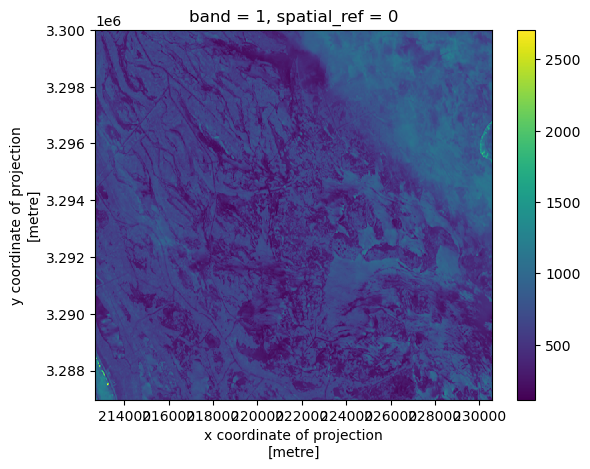

In [47]:
test_cropped_da.plot()

In [48]:
mask_bits=[0, 1, 2, 3, 6, 7]
# Unpack bits into a new axis
bits = (
    ### make each number in the dataarray binary
    np.unpackbits(
        ### change dataarray integer type to unsigned 8 bit integer type
        ### there will be 8 bits per number
        ### we do this because python will read the numbers as integers otherwise
        test_da.astype(np.uint8), bitorder='little'
    ).reshape(test_da.shape + (-1,))
)

# Select the required bits and check if any are flagged
# if the mask_bits equal 0, that means there isn't clouds, high aerosols, etc, so we only want to keep those bits.
# this will get rid of mask_bits that equal 1, aka where clouds, high aerosols, etc are.
mask = np.prod(bits[..., mask_bits]==0,
                ### add an axis so each number is converted to an array of 8 bits
                ### each row has 1 number from original array in 8 bit format
                axis=-1)
mask

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [ ]:
## what type of class is the mask object?
type(mask)

numpy.ndarray

### Merge and Composite Data

You will notice for this watershed that: 1. The raster data for each
date are spread across 4 granules 2. Any given image is incomplete
because of clouds

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>For each band:</p>
<ol type="1">
<li><p>For each date:</p>
<ol type="1">
<li>Merge all 4 granules</li>
<li>Mask any negative values created by interpolating from the nodata
value of -9999 (<code>rioxarray</code> should account for this, but
doesn’t appear to when merging. If you leave these values in they will
create problems down the line)</li>
</ol></li>
<li><p>Concatenate the merged DataArrays along a new date
dimension</p></li>
<li><p>Take the mean in the date dimension to create a composite image
that fills cloud gaps</p></li>
<li><p>Add the band as a dimension, and give the DataArray a
name</p></li>
</ol></li>
<li><p>Concatenate along the band dimension</p></li>
</ol></div></div>

In [ ]:
## how many unique datetimes are there in the reflectance_da_df datetime column?
reflectance_da_df.datetime.unique()

array([Timestamp('2023-05-04 16:31:32.101000+0000', tz='UTC'),
       Timestamp('2023-05-12 16:31:44.329000+0000', tz='UTC'),
       Timestamp('2023-05-20 16:31:23.029000+0000', tz='UTC'),
       Timestamp('2023-05-28 16:31:34.837000+0000', tz='UTC'),
       Timestamp('2023-06-05 16:31:28.153000+0000', tz='UTC'),
       Timestamp('2023-06-13 16:31:26.844000+0000', tz='UTC'),
       Timestamp('2023-06-21 16:31:34.135000+0000', tz='UTC'),
       Timestamp('2023-06-29 16:31:32.405000+0000', tz='UTC'),
       Timestamp('2023-07-07 16:31:46.664000+0000', tz='UTC'),
       Timestamp('2023-07-15 16:31:42.442000+0000', tz='UTC'),
       Timestamp('2023-07-23 16:31:50.873000+0000', tz='UTC'),
       Timestamp('2023-07-31 16:31:47.828000+0000', tz='UTC'),
       Timestamp('2023-08-08 16:31:57.564000+0000', tz='UTC'),
       Timestamp('2023-08-16 16:31:52.083000+0000', tz='UTC'),
       Timestamp('2023-08-24 16:32:05.861000+0000', tz='UTC'),
       Timestamp('2023-09-01 16:32:03.072000+0000', tz=

In [51]:
## what is the name of the dataarray in the 0 index of the reflectance_da_df?
reflectance_da_df.loc[0].da.name

'B03'

In [52]:
# Merge and composite an image for each band
## for each row in reflectance_da_df, group all of the same bands together for the same date into a tuple
## i[0] yielded the band, timestamp, and tz='UTC
## i[1] yielded the actual datetime, tile_id, band id, url, geometry, and dataarray
## i[1].da yields the dataarrays for each datetime/band combo, type = series
# for i in reflectance_da_df.groupby(['band', 'datetime']):
#     print((i[1].da))
 
## these both give me 88 dataarrays for each band id
# for i in reflectance_da_df.groupby(['band']):
#     print((i[1].da.values))
# for i in reflectance_da_df.groupby(['band', 'datetime']):
#     print((i[1].da.values))

## i[1].da.values[0] yields 220 DataArrays, 22 DataArrays for 10 different bands, 22 different datetimes
# for i in reflectance_da_df.groupby(['band', 'datetime']):
#     print(dir(i[1].da.values[0]))
#     break

# for band, band_df in tqdm(reflectance_da_df.groupby(['band'])):
#     # print(band)
#     # print(band_df)
#     for datetime, date_df in tqdm(reflectance_da_df.groupby(['datetime'])):
#         # even just printing these is taking forever
#         print(datetime)
#         print(date_df)
#         break
    
        # Merge granules for each date

        # Mask negative values

    # Composite images across dates

Solution code for merging

In [59]:
@cached('delta_reflectance_da', override=False)
def merge_and_composite_arrays(granule_da_df):
    # Merge and composite an image for each band
    df_list = []
    da_list = []
    for band, band_df in tqdm(granule_da_df.groupby('band')):
        merged_das = []
        for datetime, date_df in tqdm(band_df.groupby('datetime')):
            # Merge granules for each date
            merged_da = rxrmerge.merge_arrays(list(date_df.da))
            # Mask negative values
            merged_da = merged_da.where(merged_da>0)
            ## add merged dataarrays w/ negative values masked to the merged_das list
            merged_das.append(merged_da)
            
        # Composite images across dates
        ## concatenate merged dataarrays along the datetime dimension and
        ## reduce the dataarray's data by finding the median datetime
        composite_da = xr.concat(merged_das, dim='datetime').median('datetime')
        ## add a column to the composite_da called band
        composite_da['band'] = (
            ## [1:] will just look at elements from index 1 to the end (ignores index 0),
            ## int converts the value to an integer
            int(band[1:]))
        ## the name of the composite dataarray will be reflectance
        composite_da.name = 'reflectance'
        ## add the composite_da to the da_list
        da_list.append(composite_da)
        
    return xr.concat(da_list, dim='band')

reflectance_da = merge_and_composite_arrays(reflectance_da_df)
reflectance_da

<xarray.DataArray 'reflectance' (band: 10, y: 556, x: 624)> Size: 14MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 5kB 7.926e+05 7.926e+05 ... 8.112e+05 8.113e+05
  * y            (y) float64 4kB 3.304e+06 3.304e+06 ... 3.287e+06 3.287e+06
  * band         (band) int64 80B 1 2 3 4 5 6 7 9 10 11
    spatial_ref  int64 8B 0

## STEP 4: K-MEANS

Cluster your data by spectral signature using the k-means algorithm.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Convert your DataArray into a <strong>tidy</strong> DataFrame of
reflectance values (hint: check out the <code>.to_dataframe()</code> and
<code>.unstack()</code> methods)</li>
<li>Filter out all rows with no data (all 0s or any N/A values)</li>
<li>Fit a k-means model. You can experiment with the number of groups to
find what works best.</li>
</ol></div></div>

In [63]:
# Convert spectral DataArray to a tidy DataFrame
# Create a column for each of the bands
model_df = reflectance_da.to_dataframe().reflectance.unstack('band')

# drop bands 10 and 11 and any rows w/ NaN values
model_df = model_df.drop(columns = [10,11]).dropna()
model_df

# Check that the ranges make sense (should be from 0-1) by checking min and max values
## min_values = model_df.min()
## max_values = model_df.max()
## print(min_values)
## pring(max_values)

# Initialize k means model
## k_means = KMeans(n_clusters = 5)

# Fit model and predict
## prediction = k_means.fit_predict(model_df.values)

# Add cluster labels to df 
## model_df['clusters'] = prediction

# Running the fit and predict functions at the same time.
# We can do this since we don't have target data.

# Add the predicted values back to the model DataFrame

,band,1,2,3,4,5,6,7,9
y,x,,,,,,,,


## STEP 5: PLOT

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Create a plot that shows the k-means clusters next to an RGB image of
the area. You may need to brighten your RGB image by multiplying it by
10. The code for reshaping and plotting the clusters is provided for you
below, but you will have to create the RGB plot yourself!</p>
<p>So, what is <code>.sortby(['x', 'y'])</code> doing for us? Try the
code without it and find out.</p></div></div>

In [34]:
# make dataarray w/ bands to use for rgb
## rgb = reflectance_da.sel(band=[4, 3, 2])

# hvplot has a rgb plot method. this will not give us a helpful plot b/c the values arent what the rgb plot expects
# (
#     rgb.hvplot.rgb(y = 'y',
#                x = 'x',
#                bands = 'band',
#                data_aspect = 1,
#                xaxis = None, yaxis = None)
#                )

# Want image pixel values to range from 0-255
# Then convert to unsigned 8-bit integers (data type for images)
# don't include nan values in calculation
# This still yields a very dark plot
## rgb_uint8 = (rgb * 255).astype(np.uint8.where(rgb!=np.nan))

# We can increase the brightness of the image
# After plotting this we may get an error that the data values are too high.
## rgb_uint8_bright = (rgb_uint8 * 10)

# To fix the error, cap all pixel values at 255
# If value is 155, keep that value. if value is greater than 255, replace w/ 255
## rgb_sat = rgb_uint8_bright.where(rgb_uint8_bright < 255, 255)

In [35]:
# Plot the k-means clusters
(
    rgb_plot
    + 
    model_df.clusters.to_xarray().sortby(['x', 'y']).hvplot(
        cmap="Colorblind", aspect='equal') 
)

NameError: name 'rgb_plot' is not defined

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Don’t forget to interpret your plot!</p></div></div>

**YOUR PLOT HEADLINE AND DESCRIPTION HERE**